In [1]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
import mitsuba as mi
mi.set_variant('cuda_spectral')
import util
import numpy as np
import config
import pandas as pd
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# Load Sample Random Parameters

In [38]:
csv_name = config.param_dir +'parameters.csv'
data_csv = pd.read_csv(csv_name)
data_csv

,id_model,id_hairModel,id_lesion,id_timePoint,id_lesionMat,id_fracBlood,id_mel,id_light,id_hairAlbedo,mi_variant,lesion_scale,lesion_shape,origin_y,calChart_params,ruler_params
0,5.0,5.0,1.0,15.0,15.0,0.050,0.02,19.0,2.0,cuda_spectral,1.5,flat,15.0,"[7, 5, 4, 1]","[-1, -4]"
1,30.0,55.0,5.0,15.0,14.0,0.002,0.37,19.0,2.0,cuda_spectral,1.5,flat,15.0,"[-7, 8, 4, 0]","[-3, 6]"


# Example 1

In [39]:
row = 0 # each row corresponds to a parameter combination (model properties and light conditions)
params = data_csv.iloc[row]

id_model = int(params['id_model']) # skin models ID (used for epidermis, vascular, dermis, hypodermis)
id_hairModel = int(params['id_hairModel']) #hair model ID
id_lesion = int(params['id_lesion'])  #lesion model ID
id_timePoint = int(params['id_timePoint']) #timepoint ID for the growing lesion, which determines the size of the lesion
id_lesionMat = int(params['id_lesionMat']) #lesion material ID
id_fracBlood = float(params['id_fracBlood'])#blood fraction value
id_mel = float(params['id_mel']) #melanosome fraction value
id_light = int(params['id_light']) #light condition ID
id_hairAlbedo = int(params['id_hairAlbedo']) #hair albedo index
id_lesionScale = float(params['lesion_scale']) #lesion scale
id_origin_y = float(params['origin_y']) #distance between sensor and skin model
calChart_params = params['calChart_params'] #parameters for the calibration chart [x-locatoion, z-location, radius, color]
ruler_params = params['ruler_params' ]#parameters for the ruler [x-locatoion, z-location]
calChart_params = [int(x)  for x in calChart_params.strip("").strip("[").strip("]").split(",")]
ruler_params = [int(x) for x in ruler_params.strip("").strip("[").strip("]").split(",")]

# get material names
sel_lesionMat, sel_lightName, sel_hair_albedo = util.get_materials_names(id_lesionMat, id_light, id_hairAlbedo)
#get camera model
cam_top = util.get_sensor(id_origin_y)
# get material names
sel_lesionMat, sel_lightName, sel_hair_albedo = util.get_materials_names(id_lesionMat, id_light, id_hairAlbedo)


## Example 1: Select the Artifact and Render Image and Mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

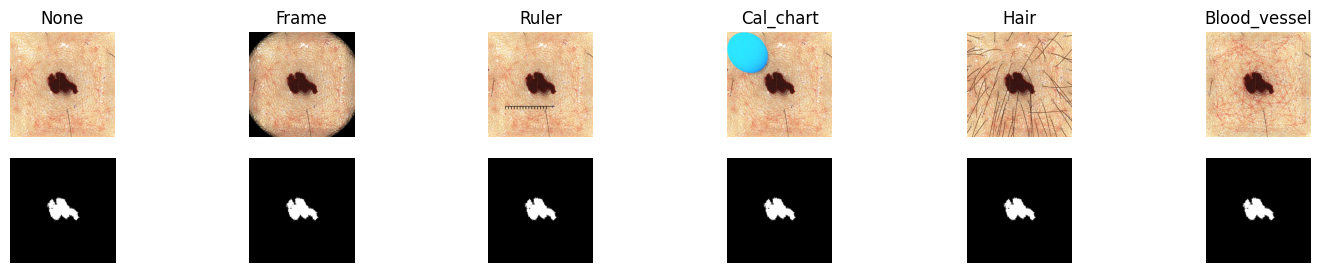

In [40]:
artifact_list = ['None','frame', 'ruler', 'cal_chart', 'hair', 'blood_vessel']

fig, ax = plt.subplots(2,len(artifact_list), figsize=(3*len(artifact_list),3))
for i, artifact in enumerate(artifact_list):
    id_frame = -1 #whether to include a dark frame or not
    id_calChart = -1 #whether to include a calibration chart or not
    id_ruler = -1 #whether to include a ruler or not
    skin_layers_directory=config.sDir_layers_orig #skin components directory (used for epidermis, vascular, dermis, hypodermis, hair)
    id_mel = float(params['id_mel']) #melanosome fraction value
    
    if artifact == 'frame':
        id_frame = 1
    if artifact == 'cal_chart':
        id_calChart = 1
    if artifact == 'ruler':
        id_ruler = 1
    if artifact == 'blood_vessel':
        skin_layers_directory = config.sDir_layers_bloodVessel
        id_mel = 0.02
    if artifact == 'hair':
        skin_layers_directory= config.sDir_layers_hair

    #rendering the skin image
    image_ref = util.render_image(id_model, id_hairModel, id_lesion,
                             sel_lesionMat, sel_lightName, sel_hair_albedo, 
                             id_fracBlood, id_mel,
                             id_timePoint, id_origin_y,
                             id_frame, id_calChart, calChart_params, id_ruler, ruler_params,
                             IMAGE=True,
                             lesion_directory=config.sDir_lesion, skin_layers_directory=skin_layers_directory, lesionScale=id_lesionScale)
    #rendering the segmentation mask
    mask_ref = util.render_image(id_model, id_hairModel, id_lesion,
                             sel_lesionMat, sel_lightName, sel_hair_albedo, 
                             id_fracBlood, id_mel,
                             id_timePoint, id_origin_y,
                             id_frame, id_calChart, calChart_params, id_ruler, ruler_params,
                             IMAGE=False,
                             lesion_directory=config.sDir_lesion, skin_layers_directory=skin_layers_directory, lesionScale=id_lesionScale)

    modified_image = mi.render(image_ref, sensor=cam_top, spp=32)
    ax[0,i].imshow(modified_image.numpy())
    ax[0,i].axis('off')
    ax[0,i].set_title(artifact.capitalize())
    modified_image = mi.render(mask_ref, sensor=cam_top, spp=32)
    ax[1,i].imshow(modified_image.numpy())
    ax[1,i].axis('off')
plt.show()